In [446]:
# !pip install netCDF4
import xarray as xr
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd
# from google.colab import drive
from matplotlib import pyplot as plt
import datetime
import glob
from dataretrieval import nwis as nwis
import datetime
from scipy.stats import linregress

In [3]:
cb_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/Platte_centerlines_masks/vector_centerlines/s2_platte_centerlines.shp').to_crs(3857)
merit_centerlines = gpd.read_file('C:/Users/dego/Documents/local_files/RSSA/MERIT/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01_bugfix1.shp').to_crs(3857)

In [4]:
Qarray = xr.open_dataset('C:/Users/dego/Documents/local_files/RSSA/grades_Q/GRADES-hydroDL_V2.0_pfaf_07_2024.nc', engine='netcdf4')

In [5]:
rwc_dfs = []

files = glob.glob('C:/Users/dego/Documents/local_files/RSSA/all_rwc_exports/*.csv')

for f in files:
    rwc_dfs.append(pd.read_csv(f))

rwc_df = pd.concat(rwc_dfs)

In [244]:
rwc_gdf = gpd.GeoDataFrame(rwc_df, geometry=gpd.points_from_xy(rwc_df.x, rwc_df.y, crs=4326))
rwc_gdf.scene_date = pd.to_datetime(rwc_gdf.scene_date, format='ISO8601').dt.date
rwc_gdf = rwc_gdf.rename(columns={'scene_date': 'date'})
rwc_gdf

,system:index,MLength,any,cloud_mask,cloudwater_mask,count,endsInWater,endsOverEdge,iindex,img_id,river_mask,scene_cloudy_pixel_percentage,date,snow_mask,width,x,y,.geo,geometry
0,20181001T174131_20181001T174133_T14TLN_0000000...,30.0,0,0.307197,0.0,2,0,0,7678,S2A_MSIL2A_20181001T174131_N0500_R098_T14TLN_2...,0.000000,10.924859,2018-10-01,0.0,0.000000,-100.971220,42.381660,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-100.97122 42.38166)
1,20181001T174131_20181001T174133_T14TLN_0000000...,30.0,1,0.000000,0.0,2,1,0,8065,S2A_MSIL2A_20181001T174131_N0500_R098_T14TLN_2...,1.000000,10.924859,2018-10-01,0.0,30.000000,-100.927115,42.376630,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-100.92711 42.37663)
2,20181001T174131_20181001T174133_T14TLN_0000000...,30.0,0,0.000000,0.0,2,0,0,7323,S2A_MSIL2A_20181001T174131_N0500_R098_T14TLN_2...,0.523256,10.924859,2018-10-01,0.0,15.697674,-100.984428,42.389566,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-100.98443 42.38957)
3,20181001T174131_20181001T174133_T14TLN_0000000...,30.0,0,1.000000,0.0,2,0,0,6288,S2A_MSIL2A_20181001T174131_N0500_R098_T14TLN_2...,0.000000,10.924859,2018-10-01,0.0,0.000000,-100.893609,42.369263,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-100.89361 42.36926)
4,20181001T174131_20181001T174133_T14TLN_0000000...,30.0,0,1.000000,0.0,2,0,0,7534,S2A_MSIL2A_20181001T174131_N0500_R098_T14TLN_2...,0.000000,10.924859,2018-10-01,0.0,0.000000,-100.974096,42.383278,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-100.9741 42.38328)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159410,20240930T180049_20240930T180827_T13TDH_0000000...,159.0,0,0.000000,0.0,2,0,0,50066,S2B_MSIL2A_20240930T180049_N0511_R041_T13TDH_2...,0.206302,0.000000,2024-09-30,0.0,32.801978,-105.929562,42.865494,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-105.92956 42.86549)
159411,20240930T180049_20240930T180827_T13TDH_0000000...,159.0,0,0.000000,0.0,2,0,0,50972,S2B_MSIL2A_20240930T180049_N0511_R041_T13TDH_2...,0.294618,0.000000,2024-09-30,0.0,46.844296,-106.091258,42.863787,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-106.09126 42.86379)
159412,20240930T180049_20240930T180827_T13TDH_0000000...,159.0,0,0.000000,0.0,2,0,0,51116,S2B_MSIL2A_20240930T180049_N0511_R041_T13TDH_2...,0.176633,0.000000,2024-09-30,0.0,28.084637,-106.110392,42.860193,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-106.11039 42.86019)
159413,20240930T180049_20240930T180827_T13TDH_0000000...,159.0,0,0.000000,0.0,2,0,0,51141,S2B_MSIL2A_20240930T180049_N0511_R041_T13TDH_2...,0.264259,0.000000,2024-09-30,0.0,42.017249,-106.136085,42.860014,"{""type"":""MultiPoint"",""coordinates"":[]}",POINT (-106.13609 42.86001)


In [227]:
gage_list = ['06764880', '06775900', '06775500', '06770200', '06767970', '06768000',
             '06784000', '06781900', '06785000', '06790500', '06800500', '06793000',
             '06800000', '06777495', '06786000', '06799350', '06799315', '06799000',
             '06797500', '06785500', '06710247', '06711565', '06714215', '06721000',
             '06759500', '06620000', '06680500', '06630000', '06674500', '06635000',
             '06670500', '06657000', '06652000']




In [228]:
gages = nwis.get_info(sites=gage_list)[0][['site_no', 'geometry']]
gages

,site_no,geometry
0,06620000,POINT (-106.33919 40.93664)
1,06630000,POINT (-107.0576 41.87217)
2,06635000,POINT (-106.51314 42.00967)
3,06652000,POINT (-105.15921 42.65248)
4,06657000,POINT (-104.62802 42.24101)
5,06670500,POINT (-104.53835 42.20051)
6,06674500,POINT (-104.05334 41.98857)
7,06680500,POINT (-103.67556 41.84994)
8,06710247,POINT (-105.01498 39.63249)
9,06711565,POINT (-105.00415 39.66499)


In [229]:
gage_buffers = gages.to_crs(3857)
# gages = gages.rename({'geometry': 'point'})
buffgeoms = gage_buffers.apply(lambda x: x['geometry'].buffer(1500), axis=1)
gage_buffers = gage_buffers.set_geometry(buffgeoms, crs=3857)
gage_buffers = gage_buffers.to_crs(4326)

In [ ]:
rwc_points = rwc_gdf.geometry.unique()
n_geoms = len(rwc_points)
gindex = range(n_geoms)
geom_gindex = gpd.GeoDataFrame({'geometry': rwc_points, 'gindex': gindex})

In [243]:
geom_COMID = gpd.GeoDataFrame(geometry=rwc_points, crs=4326).to_crs(3857).sjoin_nearest(merit_centerlines, max_distance=1000).to_crs(4326)
print(len(geom_COMID))

19226


In [245]:
rwc_gdf = pd.merge(rwc_gdf, geom_gindex, how='left', on='geometry')
rwc_gdf = pd.merge(rwc_gdf, geom_COMID, how='left', on='geometry')

In [246]:
# geom_gindex = geom_gindex.to_crs(3857)
gage_rwc_points = geom_gindex.sjoin(gage_buffers, predicate='within').to_crs(4326)
gage_rwc_points

,geometry,gindex,index_right,site_no
170,POINT (-101.57759 41.12483),170,13,06764880
178,POINT (-101.56977 41.12483),178,13,06764880
190,POINT (-101.56689 41.12501),190,13,06764880
226,POINT (-101.57157 41.12546),226,13,06764880
230,POINT (-101.56402 41.12573),230,13,06764880
...,...,...,...,...
19366,POINT (-105.15576 42.649),19366,3,06652000
19387,POINT (-105.15764 42.65143),19387,3,06652000
19417,POINT (-105.15503 42.64837),19417,3,06652000
19489,POINT (-105.15369 42.6481),19489,3,06652000


In [247]:
print(len(rwc_gdf.loc[rwc_gdf.uparea >= 0]))
print(len(rwc_gdf))

2596917
7982702


In [249]:
gage_rwc = pd.merge(gage_rwc_points[['gindex', 'site_no']], rwc_gdf, how='left', on='gindex')

In [257]:
gage_COMID = gpd.sjoin_nearest(gages.to_crs(3857), merit_centerlines, max_distance=1000)[['site_no', 'COMID']]
gage_COMID_rwc = pd.merge(gage_COMID, rwc_gdf, how='left', on='COMID')

In [546]:
gage_rwc_filt = gage_rwc.loc[(gage_rwc.cloud_mask - gage_rwc.cloudwater_mask == 0) & 
                             (gage_rwc.snow_mask == 0) & 
                             (gage_rwc.endsInWater == 0) & 
                             (gage_rwc.endsOverEdge == 0) & 
                             (gage_rwc.width >= 0)]

gage_COMID_rwc_filt = gage_COMID_rwc.loc[(gage_COMID_rwc.cloud_mask - gage_COMID_rwc.cloudwater_mask == 0) & 
                                         (gage_COMID_rwc.snow_mask == 0) & 
                                         (gage_COMID_rwc.endsInWater == 0) & 
                                         (gage_COMID_rwc.endsOverEdge == 0) & 
                                         (gage_COMID_rwc.width > 0)]

In [ ]:
gage_rwc_stats = gage_rwc_filt.groupby(['site_no', 'date']).agg(
    overall_mean_width = ('width', lambda x: x.mean()),
    median_width = ('width', lambda x: x.median()),
    sd_width = ('width', lambda x: x.std()),
    w05 = ('width', lambda x: x.quantile(0.05)),
    w10 = ('width', lambda x: x.quantile(0.10)),
    w20 = ('width', lambda x: x.quantile(0.20)),
    w30 = ('width', lambda x: x.quantile(0.30)),
    w40 = ('width', lambda x: x.quantile(0.40)),
    w50 = ('width', lambda x: x.quantile(0.50)),
    w60 = ('width', lambda x: x.quantile(0.60)),
    w70 = ('width', lambda x: x.quantile(0.70)),
    w80 = ('width', lambda x: x.quantile(0.80)),
    w90 = ('width', lambda x: x.quantile(0.90)),
    w95 = ('width', lambda x: x.quantile(0.95)),
    n_meas = ('width', lambda x: len(x))
)

In [574]:
gage_COMID_rwc_stats = gage_COMID_rwc_filt.groupby(['site_no', 'date']).agg(
    overall_mean_width = ('width', lambda x: x.mean()),
    median_width = ('width', lambda x: x.median()),
    sd_width = ('width', lambda x: x.std()),
    w05 = ('width', lambda x: x.quantile(0.05)),
    w10 = ('width', lambda x: x.quantile(0.10)),
    w20 = ('width', lambda x: x.quantile(0.20)),
    w30 = ('width', lambda x: x.quantile(0.30)),
    w40 = ('width', lambda x: x.quantile(0.40)),
    w50 = ('width', lambda x: x.quantile(0.50)),
    w60 = ('width', lambda x: x.quantile(0.60)),
    w70 = ('width', lambda x: x.quantile(0.70)),
    w80 = ('width', lambda x: x.quantile(0.80)),
    w90 = ('width', lambda x: x.quantile(0.90)),
    w95 = ('width', lambda x: x.quantile(0.95)),
    max_width = ('width', lambda x: x.max()),
    min_width = ('width', lambda x: x.min()),
    n_meas = ('width', lambda x: len(x)),
    middle_mean = ('width', lambda x: mean_0595(x, 0.2, 0.99))
)

In [ ]:
# gage_COMID_rwc_filt['month'] = gage_COMID_rwc_filt.apply(lambda x: x.date.month, axis=1)
# gage_COMID_rwc_filt.columns
gage_COMID_month_stats = gage_COMID_rwc_filt.groupby(['site_no', 'month']).agg(
    overall_mean_width = ('width', lambda x: x.mean()),
    median_width = ('width', lambda x: x.median()),
    sd_width = ('width', lambda x: x.std()),
    w05 = ('width', lambda x: x.quantile(0.05)),
    w10 = ('width', lambda x: x.quantile(0.10)),
    w90 = ('width', lambda x: x.quantile(0.90)),
    w95 = ('width', lambda x: x.quantile(0.95)),
    max_width = ('width', lambda x: x.max()),
    min_width = ('width', lambda x: x.min()),
    n_meas = ('width', lambda x: len(x))
)

C:\Users\dego\AppData\Local\Temp\ipykernel_106416\758360946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gage_COMID_rwc_filt['month'] = gage_COMID_rwc_filt.apply(lambda x: x.date.month, axis=1)


In [548]:
gage_COMID_rwc_stats

overall_mean_width  median_width   sd_width        w05  \
site_no  date                                                                 
06620000 2018-04-22           19.857454     19.857454        NaN  19.857454   
         2018-04-27           19.857454     19.857454        NaN  19.857454   
         2018-06-11           19.390642     19.390642        NaN  19.390642   
         2018-07-01           19.390642     19.390642        NaN  19.390642   
         2018-07-26           19.390642     19.390642        NaN  19.390642   
...                                 ...           ...        ...        ...   
06800500 2024-11-19           75.914399     75.147248  20.178319  48.429941   
         2024-12-04           73.516936     69.338568  21.681639  46.124139   
         2024-12-09           76.597316     75.273299  22.404975  45.474771   
         2024-12-19           73.439288     70.710464  21.990476  42.004782   
         2024-12-22           77.920363     71.781663  21.507596  50.164007   

                           w10         w90         w95   max_width  min_width  \
site_no  date                                                                   
06620000 2018-04-22  19.857454   19.857454   19.857454   19.857454  19.857454   
         2018-04-27  19.857454   19.857454   19.857454   19.857454  19.857454   
         2018-06-11  19.390642   19.390642   19.390642   19.390642  19.390642   
         2018-07-01  19.390642   19.390642   19.390642   19.390642  19.390642   
         2018-07-26  19.390642   19.390642   19.390642   19.390642  19.390642   
...                        ...         ...         ...         ...        ...   
06800500 2024-11-19  49.630846  102.076878  113.684070  124.211043  40.266168   
         2024-12-04  47.648251  103.761327  116.150943  124.211043  37.810717   
         2024-12-09  50.403740  108.961553  119.566351  127.072170   7.580566   
         2024-12-19  48.673135  105.154327  113.793594  123.310298  30.102539   
         2024-12-22  52.655709  110.041126  117.034865  124.211043  45.642178   

                     n_meas  middle_mean  
site_no  date                             
06620000 2018-04-22       1    19.857454  
         2018-04-27       1    19.857454  
         2018-06-11       1    19.390642  
         2018-07-01       1    19.390642  
         2018-07-26       1    19.390642  
...                     ...          ...  
06800500 2024-11-19      62    77.245314  
         2024-12-04      62    74.945073  
         2024-12-09     124    78.912805  
         2024-12-19      62    75.265469  
         2024-12-22      62    79.189354  

[9672 rows x 11 columns]

In [ ]:
def mean_0595(x, l, u):
    p05 = x.quantile(l)
    p95 = x.quantile(u)
    t = x[(x >= p05) & (x <= p95)]

    return t.mean()


tdf = gage_COMID_rwc_filt.loc[(gage_COMID_rwc_filt.site_no == '06800000')]
# print(len(tdf.loc[tdf.width > 0]))
# print(len(tdf.loc[tdf.width >= 0]))
print(mean_0595(tdf.width, 0.05, 0.95))
print()

1.0687936375718496


In [534]:
n = 0
g = gage_list[n]
df = gage_COMID_rwc_stats.loc[g]

# fig, ax= plt.subplots()
# ax.plot(df.index, df.w95)

In [535]:
df = df.reset_index()
df.date = pd.to_datetime(df.date)
# df
df['roll_10d'] = df.rolling('10D', on='date')['overall_mean_width'].mean()
df

,date,overall_mean_width,median_width,sd_width,w05,w10,w90,w95,max_width,min_width,n_meas,roll_10d
0,2018-03-15,19.014565,20.143075,9.361999,0.000000,0.000000,28.039356,28.747412,30.292062,0.0,26,19.014565
1,2018-03-17,3.016176,0.000000,5.406185,0.000000,0.000000,9.579573,13.833153,18.988636,0.0,27,11.015371
2,2018-03-22,1.691061,0.000000,3.523860,0.000000,0.000000,9.329094,9.427064,9.464393,0.0,27,7.907267
3,2018-03-27,1.155481,0.000000,3.017670,0.000000,0.000000,6.071030,9.407375,9.464393,0.0,29,1.423271
4,2018-04-09,10.067650,10.539606,6.490280,1.421053,2.842105,17.296033,18.000958,18.705882,0.0,8,10.067650
...,...,...,...,...,...,...,...,...,...,...,...,...
408,2024-11-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,30,0.000000
409,2024-11-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,30,0.000000
410,2024-12-03,2.668887,0.000000,4.537858,0.000000,0.000000,10.091877,11.306794,15.124811,0.0,30,0.889629
411,2024-12-05,8.099187,9.212256,7.366801,0.000000,0.000000,18.880329,19.001921,19.953875,0.0,29,3.589358


IFMHA

In [133]:
gage_nums = [int(site_no) for site_no in gage_list]
ifmha = pd.read_csv(r'C:\Users\dego\Documents\local_files\RSSA\IFMHA\IFMHA.csv')

ifmha = ifmha.loc[ifmha.site_no.isin(gage_nums)]

ifmha.measurement_dt = pd.to_datetime(ifmha.measurement_dt)
ifmha = ifmha.loc[(ifmha.measurement_dt >= datetime.datetime(2018, 1, 1)) & (ifmha.measurement_dt <= datetime.datetime(2024, 12, 31))]

ifmha['date'] = ifmha.measurement_dt.dt.date
ifmha.chan_width = ifmha.chan_width / 3.28
ifmha.site_no = ifmha.apply(lambda x: f'0{x.site_no}', axis=1)


ifmha = ifmha[['site_no', 'date', 'chan_width']]

C:\Users\dego\AppData\Local\Temp\ipykernel_106416\2328685556.py:2: DtypeWarning: Columns (4,8,37) have mixed types. Specify dtype option on import or set low_memory=False.
  ifmha = pd.read_csv(r'C:\Users\dego\Documents\local_files\RSSA\IFMHA\IFMHA.csv')


In [ ]:
width_dfs = []
for gage in (gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['chan_width'] = isw.width_ft / 3.28
isw = isw[['date', 'chan_width', 'site_no']]

C:\Users\dego\AppData\Local\Temp\ipykernel_106416\1985079103.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  isw = pd.concat(width_dfs)


,date,chan_width,site_no
0,2013-09-19,140.243902,06764880
1,2011-06-27,138.414634,06764880
2,2013-09-19,140.243902,06764880
3,2013-09-24,166.158537,06764880
0,2021-05-26,15.853659,06775900
...,...,...,...
8,2008-06-16,30.487805,06635000
9,2024-05-29,29.878049,06635000
10,2025-04-04,30.487805,06635000
11,2025-07-02,11.585366,06635000


In [432]:
all_isw = pd.concat([isw, ifmha])
all_isw = all_isw.loc[(all_isw.date >= datetime.date(2017, 12, 31)) & (all_isw.date <= datetime.date(2025, 1, 31))]
all_isw.date = pd.to_datetime(all_isw.date).dt.date
all_isw

,date,chan_width,site_no
0,2021-05-26,15.853659,06775900
4,2019-08-21,14.024390,06775900
5,2020-09-16,15.243902,06775900
7,2019-09-04,16.463415,06775900
9,2021-11-29,20.121951,06775900
...,...,...,...
1711697,2022-04-27,66.768293,06800500
1711698,2022-06-10,71.646341,06800500
1711699,2022-07-18,61.890244,06800500
1711700,2022-08-15,54.878049,06800500


MultiIndex([('06620000', 2018-03-24),
            ('06620000', 2018-03-25),
            ('06620000', 2018-03-26),
            ('06620000', 2018-03-27),
            ('06620000', 2018-03-28),
            ('06620000', 2018-03-29),
            ('06620000', 2018-03-30),
            ('06620000', 2018-03-31),
            ('06620000', 2018-04-01),
            ('06620000', 2018-04-02),
            ...
            ('06800500', 2024-12-22),
            ('06800500', 2024-12-23),
            ('06800500', 2024-12-24),
            ('06800500', 2024-12-25),
            ('06800500', 2024-12-26),
            ('06800500', 2024-12-27),
            ('06800500', 2024-12-28),
            ('06800500', 2024-12-29),
            ('06800500', 2024-12-30),
            ('06800500', 2024-12-31)],
           names=['site_no', 'date'], length=67804)

In [513]:
tQ = all_isw.loc[all_isw['site_no'] == gage_list[0]]
tQ.date = pd.to_datetime(tQ.date).dt.date
    # .set_index()

# tQ = tQ.sort_values('date')
tQ.rolling('3Y', on='date', min_periods=1)['Q_cms'].mean()
# tQ

C:\Users\dego\AppData\Local\Temp\ipykernel_106416\2794917209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tQ.date = pd.to_datetime(tQ.date).dt.date


ValueError: window must be an integer 0 or greater

In [498]:
all_isw

,date,chan_width,site_no
0,2021-05-26,15.853659,06775900
4,2019-08-21,14.024390,06775900
5,2020-09-16,15.243902,06775900
7,2019-09-04,16.463415,06775900
9,2021-11-29,20.121951,06775900
...,...,...,...
1711697,2022-04-27,66.768293,06800500
1711698,2022-06-10,71.646341,06800500
1711699,2022-07-18,61.890244,06800500
1711700,2022-08-15,54.878049,06800500


In [ ]:
Q = nwis.get_dv(sites=gage_list, start='2018-01-01', end='2024-12-31', parameterCd='00060')[0]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd'}).reset_index()

Q['date'] = pd.to_datetime(Q.datetime).dt.date
Q = Q.loc[Q.Q_cd == 'A']
Q = Q[['site_no', 'Q_cms', 'date']].set_index(['site_no', 'date'])
Q['Q_percentile'] = Q.groupby('site_no')['Q_cms'].rank(pct=True)
bins = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

all_allbins = []

Q['Q_percentile_bin'] = Q.groupby('site_no')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=bins, labels=False)
)

Q

Q_cms
site_no  date                 
06620000 2018-03-24   9.323401
         2018-03-25  12.128923
         2018-03-26  12.355632
         2018-03-27  11.023717
         2018-03-28   9.748480
...                        ...
06800500 2024-12-27  30.038921
         2024-12-28  32.306010
         2024-12-29  33.439554
         2024-12-30  35.990028
         2024-12-31  36.556801

[67804 rows x 1 columns]

In [337]:
Q

Q_cms  Q_percentile  Q_percentile_bin
site_no  date                                                 
06620000 2018-03-24   9.323401      0.591856               5.0
         2018-03-25  12.128923      0.648990               6.0
         2018-03-26  12.355632      0.655303               6.0
         2018-03-27  11.023717      0.630682               6.0
         2018-03-28   9.748480      0.602273               6.0
...                        ...           ...               ...
06800500 2024-12-27  30.038921      0.274314               2.0
         2024-12-28  32.306010      0.312968               3.0
         2024-12-29  33.439554      0.327681               3.0
         2024-12-30  35.990028      0.363092               3.0
         2024-12-31  36.556801      0.369825               3.0

[67804 rows x 3 columns]

In [549]:
paired_Qw = gage_COMID_rwc_stats.join(all_isw.set_index(['site_no', 'date']), how='outer').join(Q, how='outer')
paired_Qw

overall_mean_width  median_width  sd_width  w05  w10  \
site_no  date                                                               
06620000 2018-01-17                 NaN           NaN       NaN  NaN  NaN   
         2018-03-13                 NaN           NaN       NaN  NaN  NaN   
         2018-03-24                 NaN           NaN       NaN  NaN  NaN   
         2018-03-25                 NaN           NaN       NaN  NaN  NaN   
         2018-03-26                 NaN           NaN       NaN  NaN  NaN   
...                                 ...           ...       ...  ...  ...   
06800500 2024-12-28                 NaN           NaN       NaN  NaN  NaN   
         2024-12-29                 NaN           NaN       NaN  NaN  NaN   
         2024-12-30                 NaN           NaN       NaN  NaN  NaN   
         2024-12-31                 NaN           NaN       NaN  NaN  NaN   
         2025-01-22                 NaN           NaN       NaN  NaN  NaN   

                     w90  w95  max_width  min_width  n_meas  middle_mean  \
site_no  date                                                              
06620000 2018-01-17  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-13  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-24  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-25  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-26  NaN  NaN        NaN        NaN     NaN          NaN   
...                  ...  ...        ...        ...     ...          ...   
06800500 2024-12-28  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-29  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-30  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-31  NaN  NaN        NaN        NaN     NaN          NaN   
         2025-01-22  NaN  NaN        NaN        NaN     NaN          NaN   

                     chan_width      Q_cms  Q_percentile  Q_percentile_bin  
site_no  date                                                               
06620000 2018-01-17   35.670732        NaN           NaN               NaN  
         2018-03-13   51.524390        NaN           NaN               NaN  
         2018-03-24         NaN   9.323401      0.591856               5.0  
         2018-03-25         NaN  12.128923      0.648990               6.0  
         2018-03-26         NaN  12.355632      0.655303               6.0  
...                         ...        ...           ...               ...  
06800500 2024-12-28         NaN  32.306010      0.312968               3.0  
         2024-12-29         NaN  33.439554      0.327681               3.0  
         2024-12-30         NaN  35.990028      0.363092               3.0  
         2024-12-31         NaN  36.556801      0.369825               3.0  
         2025-01-22   70.121951        NaN           NaN               NaN  

[69357 rows x 15 columns]

In [430]:
gage_COMID_rwc_filt.set_index(['site_no', 'date'])

COMID  \
site_no  date                   
06620000 2018-10-19  74030717   
         2018-10-19  74030717   
         2018-10-19  74030717   
         2018-10-19  74030717   
         2018-10-19  74030717   
...                       ...   
06800500 2024-09-30  74029691   
         2024-09-30  74029691   
         2024-09-30  74029691   
         2024-09-30  74029691   
         2024-09-30  74029691   

                                                          system:index  \
site_no  date                                                            
06620000 2018-10-19  20181019T175329_20181019T175857_T13TCF_0000000...   
         2018-10-19  20181019T175329_20181019T175857_T13TCF_0000000...   
         2018-10-19  20181019T175329_20181019T175857_T13TCF_0000000...   
         2018-10-19  20181019T175329_20181019T175857_T13TCF_0000000...   
         2018-10-19  20181019T175329_20181019T175857_T13TCF_0000000...   
...                                                                ...   
06800500 2024-09-30  20240930T171121_20240930T172042_T15TTF_0000000...   
         2024-09-30  20240930T171121_20240930T172042_T15TTF_0000000...   
         2024-09-30  20240930T171121_20240930T172042_T15TTF_0000000...   
         2024-09-30  20240930T171121_20240930T172042_T15TTF_0000000...   
         2024-09-30  20240930T171121_20240930T172042_T15TTF_0000000...   

                     MLength  any  cloud_mask  cloudwater_mask  count  \
site_no  date                                                           
06620000 2018-10-19     66.0  0.0         0.0              0.0    2.0   
         2018-10-19     66.0  0.0         0.0              0.0    2.0   
         2018-10-19     30.0  0.0         0.0              0.0    2.0   
         2018-10-19     30.0  0.0         0.0              0.0    2.0   
         2018-10-19     84.0  0.0         0.0              0.0    2.0   
...                      ...  ...         ...              ...    ...   
06800500 2024-09-30    234.0  0.0         0.0              0.0    2.0   
         2024-09-30    339.0  0.0         0.0              0.0    2.0   
         2024-09-30    423.0  0.0         0.0              0.0    2.0   
         2024-09-30    300.0  0.0         0.0              0.0    2.0   
         2024-09-30    342.0  0.0         0.0              0.0    2.0   

                     endsInWater  endsOverEdge    iindex  ... order  \
site_no  date                                             ...         
06620000 2018-10-19          0.0           0.0   42031.0  ...   4.0   
         2018-10-19          0.0           0.0   41900.0  ...   4.0   
         2018-10-19          0.0           0.0   43857.0  ...   4.0   
         2018-10-19          0.0           0.0   42024.0  ...   4.0   
         2018-10-19          0.0           0.0   42101.0  ...   4.0   
...                          ...           ...       ...  ...   ...   
06800500 2024-09-30          0.0           0.0  246048.0  ...   5.0   
         2024-09-30          0.0           0.0  246316.0  ...   5.0   
         2024-09-30          0.0           0.0  155284.0  ...   5.0   
         2024-09-30          0.0           0.0  155255.0  ...   5.0   
         2024-09-30          0.0           0.0  155192.0  ...   5.0   

                     strmDrop_t  slope_taud  NextDownID  maxup         up1  \
site_no  date                                                                
06620000 2018-10-19         5.8    0.000855  74030680.0    2.0  74030731.0   
         2018-10-19         5.8    0.000855  74030680.0    2.0  74030731.0   
         2018-10-19         5.8    0.000855  74030680.0    2.0  74030731.0   
         2018-10-19         5.8    0.000855  74030680.0    2.0  74030731.0   
         2018-10-19         5.8    0.000855  74030680.0    2.0  74030731.0   
...                         ...         ...         ...    ...         ...   
06800500 2024-09-30        11.1    0.000416  74029094.0    2.0  74029705.0   
         2024-09-30        11.1    0.000416  74029094.0

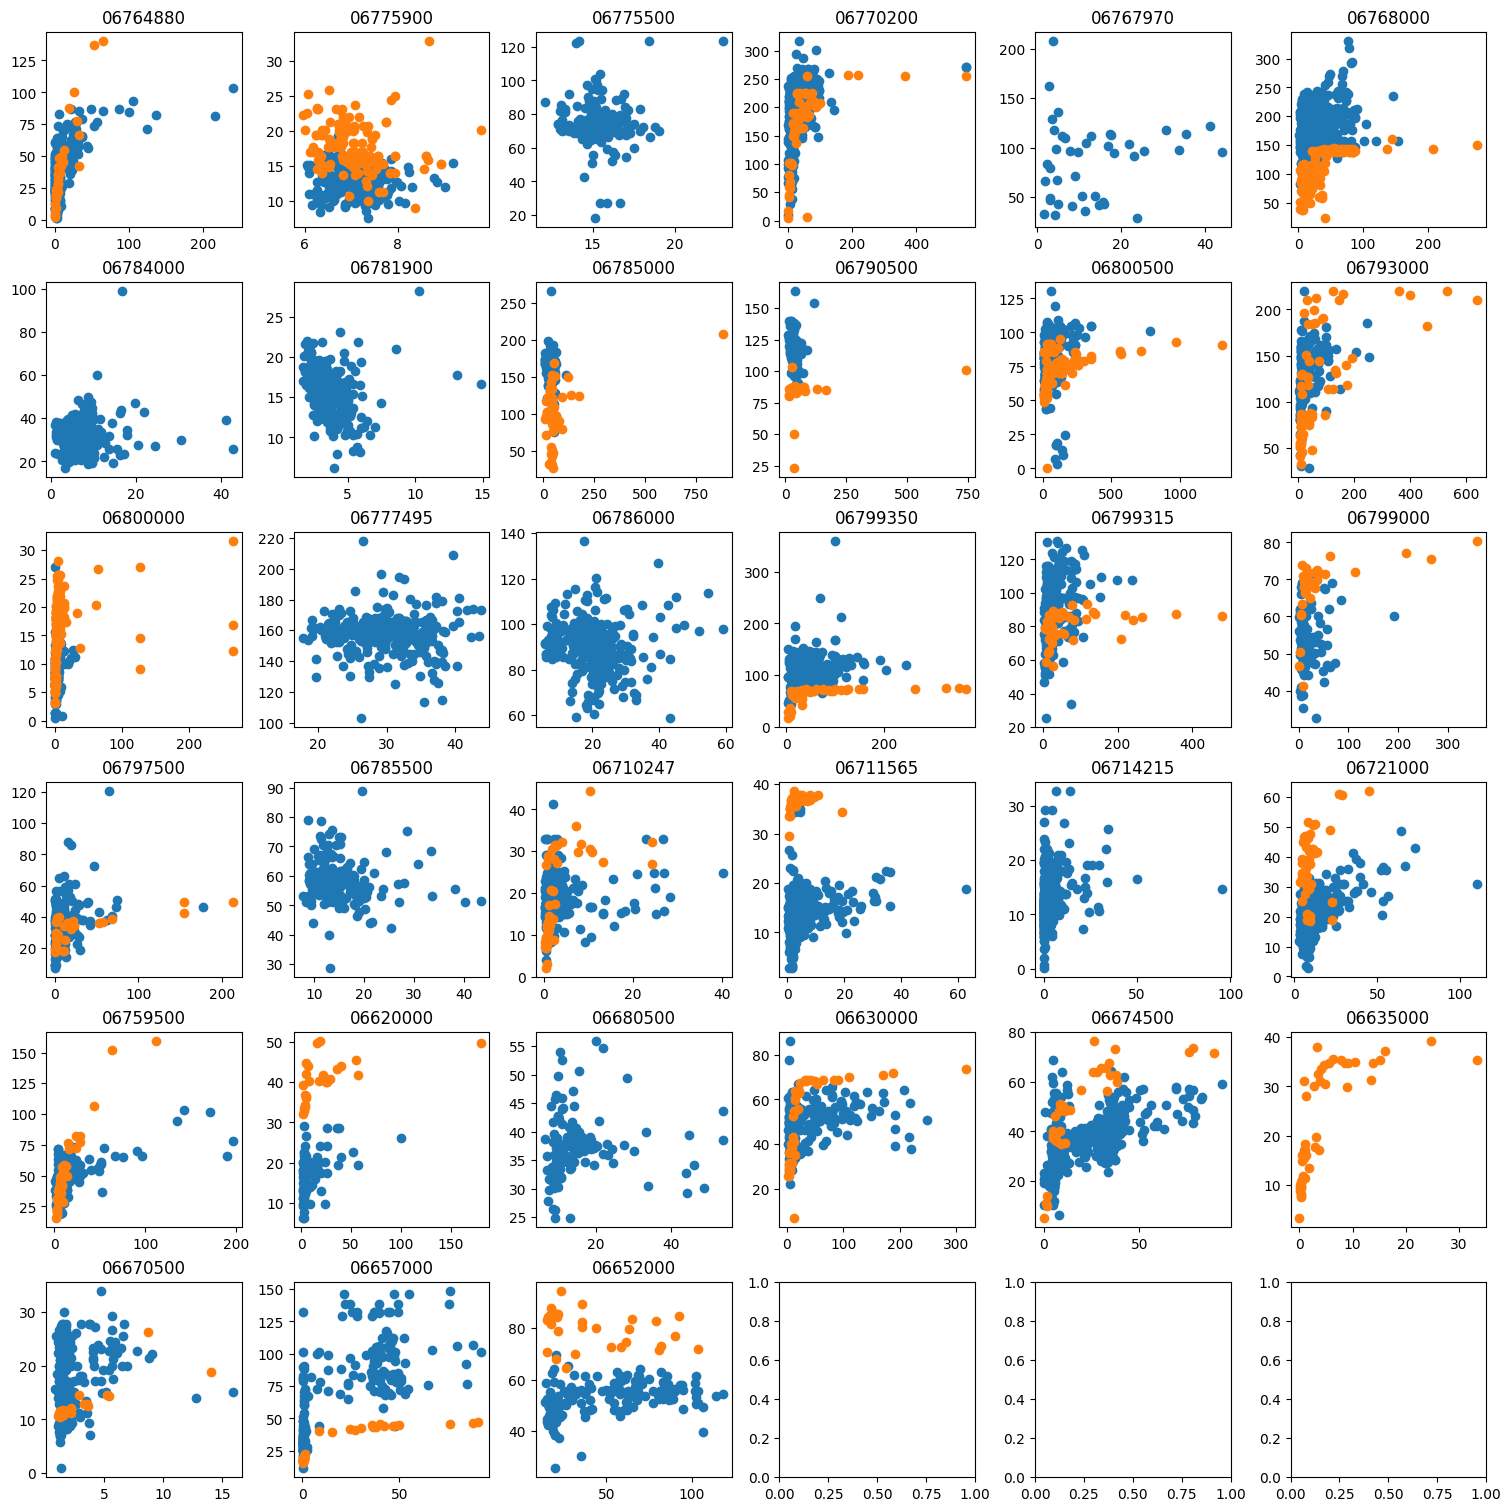

In [550]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15), constrained_layout=True)

for g in range(len(gage_list)):
    tempdf = paired_Qw.loc[gage_list[g]]
    ax = axs.flatten()[g]

    ax.scatter(tempdf.Q_cms, tempdf.overall_mean_width)
    ax.scatter(tempdf.Q_cms, tempdf.chan_width)
    # ax.plot(tempdf.index, tempdf.overall_mean_width)
    # ax.plot(tempdf.index, tempdf.median_width)
    # ax.plot(tempdf.index, tempdf.midrange_mean)
    # ax.plot(tempdf.index, tempdf.chan_width, c='tab:purple')
    ax.set_title(gage_list[g])
    # ax.plot(tempdf.index, tempdf.w10, c='tab:purple')
    # ax.plot(tempdf.index, tempdf.w90, c='tab:purple')

C:\Users\dego\AppData\Local\Temp\ipykernel_106416\4226049554.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logQ'] = np.log10(df.Q_cms)
C:\Users\dego\AppData\Local\Temp\ipykernel_106416\4226049554.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_isw'] = np.log10(df.chan_width)
C:\Users\dego\AppData\Local\Temp\ipykernel_106416\4226049554.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

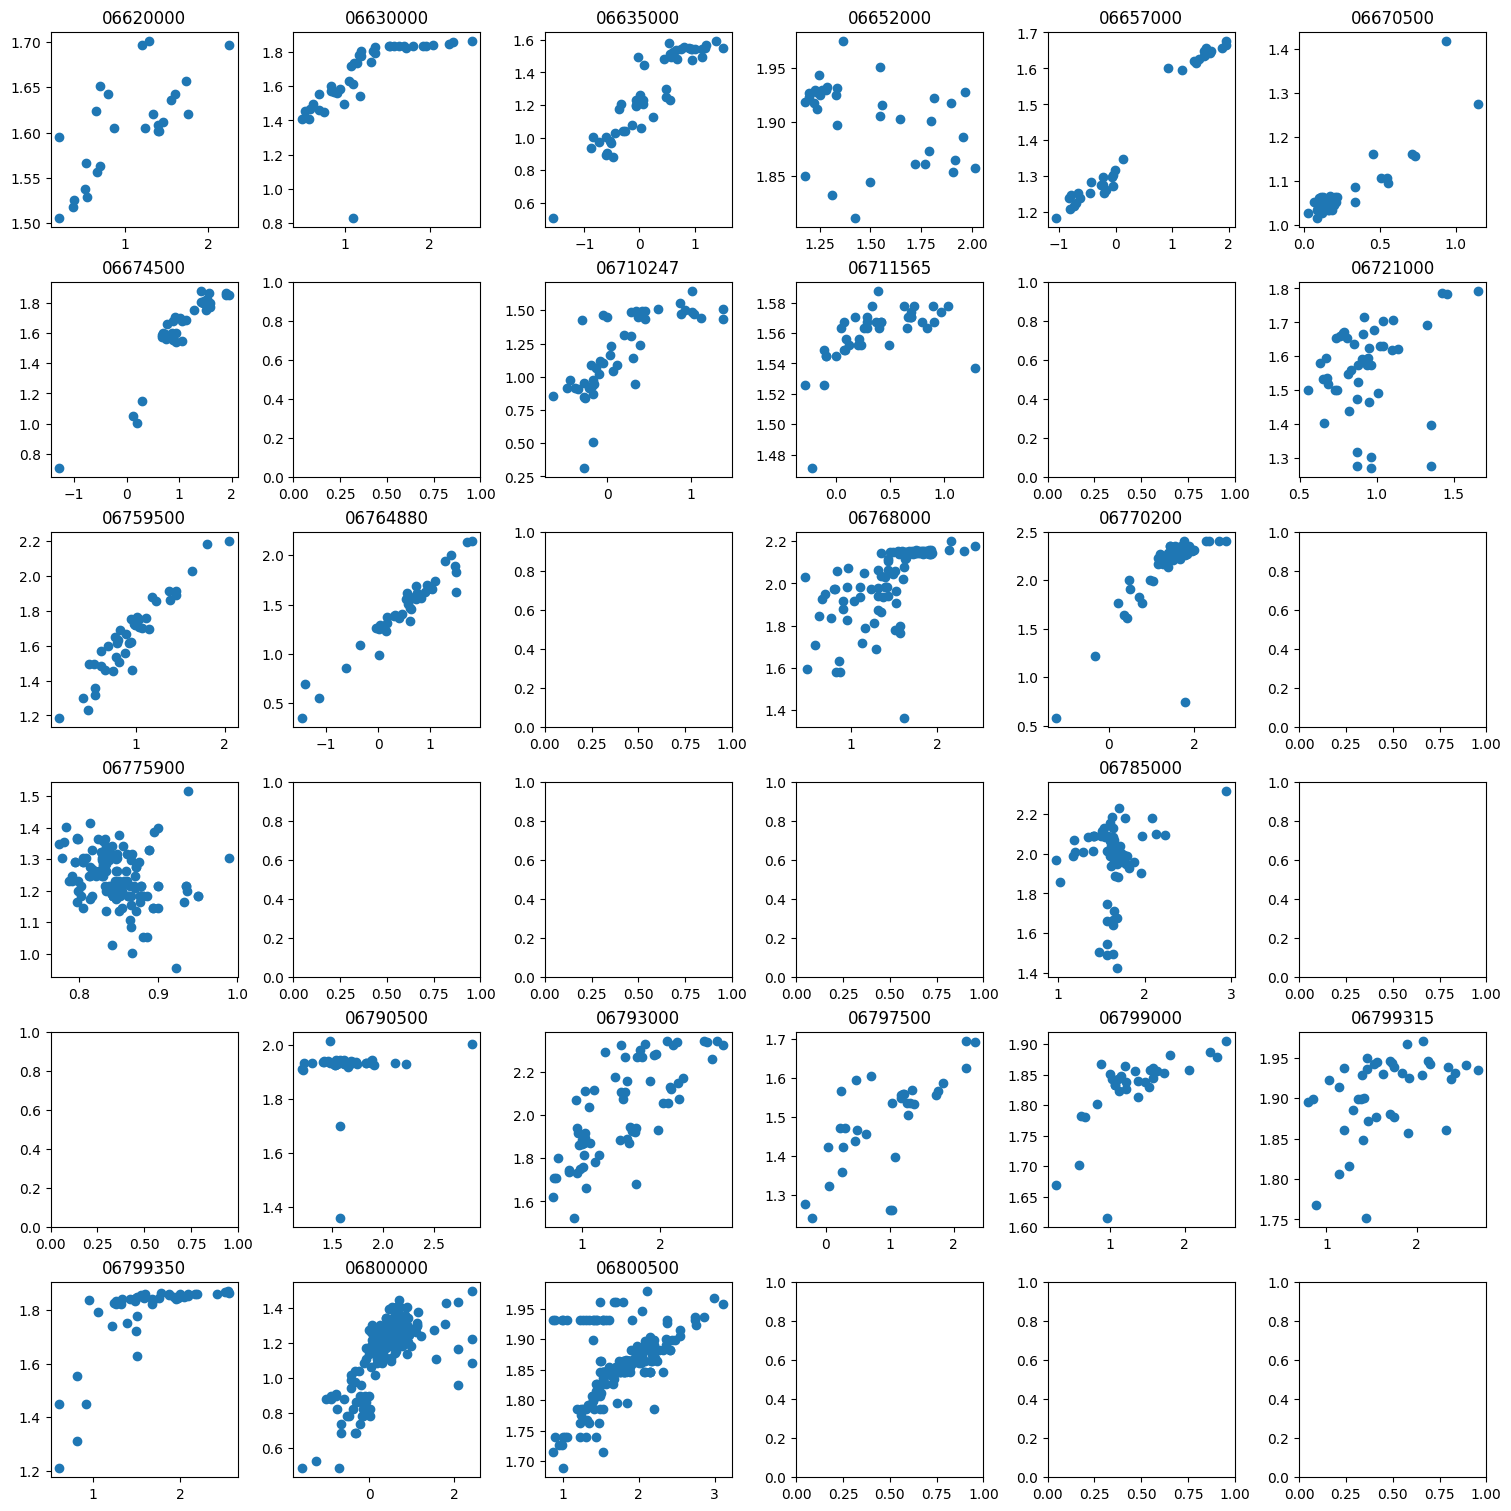

In [ ]:
rc_slopes = []
rc_intercepts = []
r2s = []
site_nos = []
n_meas = []
fig, axs = plt.subplots(6, 6, figsize=(15, 15), constrained_layout=True)

p = 0


for sn, df in paired_Qw.groupby('site_no'):

    df = df.loc[(df.Q_cms >= 0) & (df.chan_width >= 0)]

    df['logQ'] = np.log10(df.Q_cms)
    df['log_isw'] = np.log10(df.chan_width)

    if len(df) > 5:
        slope, intercept, r, pval, _ = linregress(df.logQ, df.log_isw)

        ax = axs.flatten()[p]

        ax.scatter(df.logQ, df.log_isw)

        rc_slopes.append(slope)
        rc_intercepts.append(intercept)
        r2s.append(r ** 2)
        site_nos.append(sn)
        n_meas.append(len(df))

        ax.set_title(sn)
    p += 1

In [350]:
site_nos

['06620000',
 '06630000',
 '06635000',
 '06652000',
 '06657000',
 '06670500',
 '06674500',
 '06710247',
 '06711565',
 '06721000',
 '06759500',
 '06764880',
 '06768000',
 '06770200',
 '06775900',
 '06785000',
 '06790500',
 '06793000',
 '06797500',
 '06799000',
 '06799315',
 '06799350',
 '06800000',
 '06800500']

In [353]:
rating_curve_parms = pd.DataFrame({'site_no': site_nos, 'loga': rc_intercepts, 'b': rc_slopes, 'r2': r2s, 'n_meas': n_meas}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,loga,b,r2,n_meas,a
site_no,,,,,
06620000,1.530836,0.071459,0.505187,26,33.949712
06630000,1.327849,0.271679,0.468132,41,21.273984
06635000,1.201460,0.344146,0.838188,49,15.902304
06652000,1.970773,-0.045704,0.117457,35,93.491595
06657000,1.344484,0.181462,0.972364,35,22.104678
06670500,1.010392,0.255494,0.779363,47,10.242182
06674500,1.220528,0.394849,0.852579,38,16.616064
06710247,1.102370,0.426956,0.543195,48,12.658149
06711565,1.548455,0.028845,0.307139,43,35.355364


C:\Users\dego\AppData\Local\Temp\ipykernel_106416\1276934481.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logQ'] = np.log10(df.Q_cms)
C:\Users\dego\AppData\Local\Temp\ipykernel_106416\1276934481.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_isw'] = np.log10(df.chan_width)
C:\Users\dego\AppData\Local\Temp\ipykernel_106416\1276934481.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

06620000: 0.0805243988711241
06630000: 0.09250955425944357
06635000: 0.13060446624886715
06652000: -0.057478785630516074
06657000: 0.058098029416272845
06670500: 0.3428979286101779
06674500: 0.05746383091427129
06680500: nan
06710247: 0.21424177483694992
06711565: -0.09680256631892256
06714215: nan
06721000: 0.0884716592685224
06759500: 0.0020281729235652555
06764880: 0.05214767846594444
06767970: nan
06768000: -0.18661031898151037
06770200: -0.3220138680217954
06775500: nan
06775900: 0.3821503440173596
06777495: nan
06781900: nan
06784000: nan
06785000: -0.07028052330322007
06785500: nan
06786000: nan
06790500: -0.025352479170533515
06793000: -0.16647957889237247
06797500: 0.1633969745195514
06799000: -0.04457381236111924
06799315: -0.009189281274526567
06799350: 0.09772133856421739
06800000: 0.2968596196117843
06800500: inf


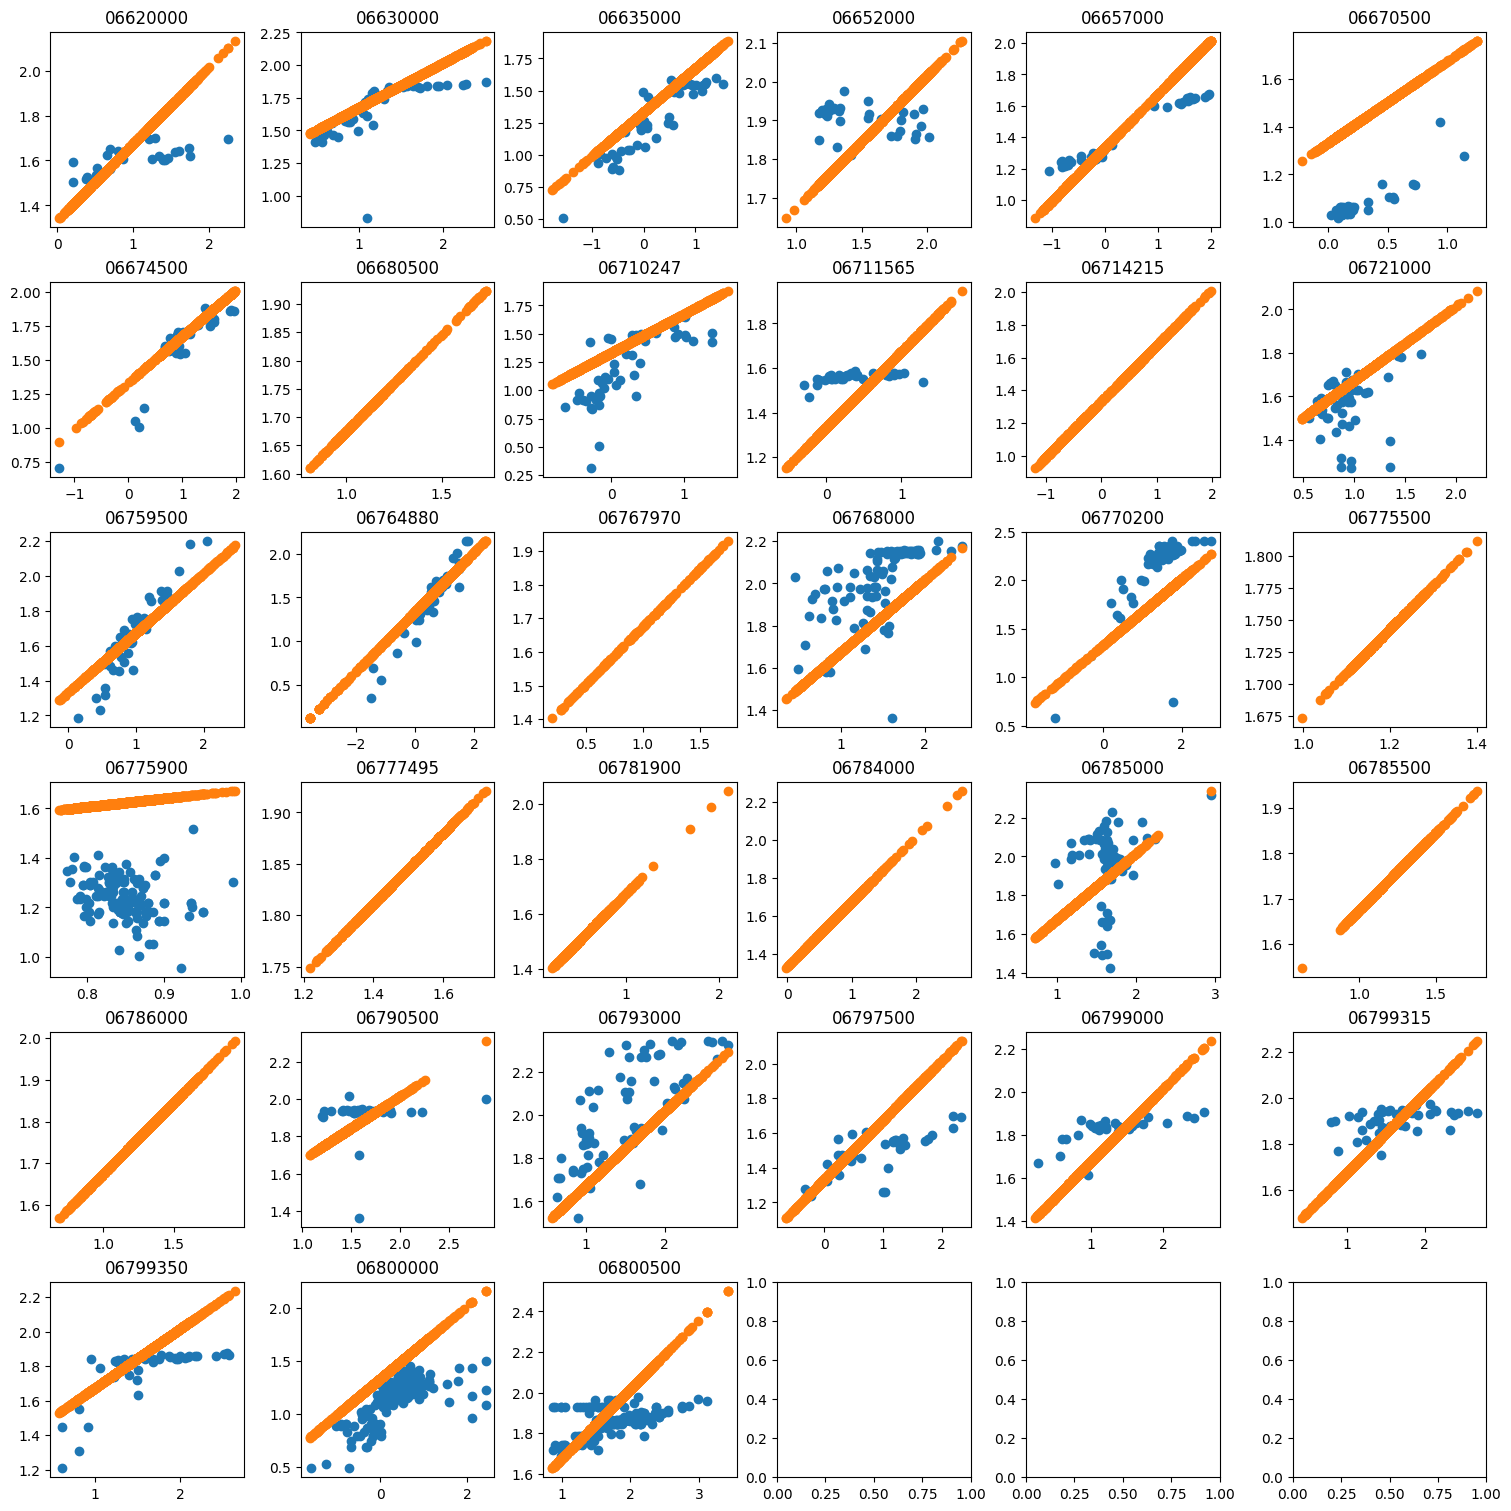

In [409]:
regional_b = (rating_curve_parms.loc[rating_curve_parms['r2'] > 0.5]['b'].mean())
regional_a = (rating_curve_parms.loc[rating_curve_parms['r2'] > 0.5]['a'].mean())

fig, axs = plt.subplots(6, 6, figsize=(15, 15), constrained_layout=True)
p = 0
res = {}
for sn, df in paired_Qw.groupby('site_no'):
# .loc[['06620000',
#  '06630000',
#  '06652000',
#  '06657000',
#  '06674500',
#  '06711565',
#  '06721000',
#  '06759500',
#  '06764880',
#  '06785000',
#  '06790500',
#  '06799000',
#  '06799315',
#  '06799350']]

    df = df.loc[(df.Q_cms >= 0)]

    df['logQ'] = np.log10(df.Q_cms)
    df['log_isw'] = np.log10(df.chan_width)
    df['predicted_w'] = regional_a * (df['Q_cms'] ** regional_b)
    df['log_predicted_w'] = np.log10(df['predicted_w'])

    if len(df) > 5:
        # slope, intercept, r, pval, _ = linregress(df.logQ, df.log_isw)

        ax = axs.flatten()[p]

        ax.scatter(df.logQ, df.log_isw)
        ax.scatter(df.logQ, df.log_predicted_w)

        # rc_slopes.append(slope)
        # rc_intercepts.append(intercept)
        # r2s.append(r ** 2)
        # site_nos.append(sn)
        # n_meas.append(len(df))

        ax.set_title(sn)

        mean_residual = (df.log_predicted_w - df.log_isw).mean()

        res[sn] = mean_residual
        print(f'{sn}: {mean_residual}')
        # ax.text(mean_residual[0].round(2), 0.8, 0.1, transform=ax.transAxes)
    p += 1

In [389]:
res

{'06620000': np.float64(0.0805243988711241),
 '06630000': np.float64(0.09250955425944357),
 '06635000': np.float64(0.13060446624886715),
 '06652000': np.float64(-0.057478785630516074),
 '06657000': np.float64(0.058098029416272845),
 '06670500': np.float64(0.3428979286101779),
 '06674500': np.float64(0.05746383091427129),
 '06680500': nan,
 '06710247': np.float64(0.21424177483694992),
 '06711565': np.float64(-0.09680256631892256),
 '06714215': nan,
 '06721000': np.float64(0.0884716592685224),
 '06759500': np.float64(0.0020281729235652555),
 '06764880': np.float64(0.05214767846594444),
 '06767970': nan,
 '06768000': np.float64(-0.18661031898151037),
 '06770200': np.float64(-0.3220138680217954),
 '06775500': nan,
 '06775900': np.float64(0.3821503440173596),
 '06777495': nan,
 '06781900': nan,
 '06784000': nan,
 '06785000': np.float64(-0.07028052330322007),
 '06785500': nan,
 '06786000': nan,
 '06790500': np.float64(-0.025352479170533515),
 '06793000': np.float64(-0.16647957889237247),
 '0

In [402]:
restable = pd.DataFrame({'id': res.keys(), 'res': res.values()})
restable['abs_res'] = restable.res.abs()

restable

,id,res,abs_res
0,06620000,0.080524,0.080524
1,06630000,0.092510,0.092510
2,06635000,0.130604,0.130604
3,06652000,-0.057479,0.057479
4,06657000,0.058098,0.058098
5,06670500,0.342898,0.342898
6,06674500,0.057464,0.057464
7,06680500,NaN,NaN
8,06710247,0.214242,0.214242
9,06711565,-0.096803,0.096803


In [551]:
paired_Qw

overall_mean_width  median_width  sd_width  w05  w10  \
site_no  date                                                               
06620000 2018-01-17                 NaN           NaN       NaN  NaN  NaN   
         2018-03-13                 NaN           NaN       NaN  NaN  NaN   
         2018-03-24                 NaN           NaN       NaN  NaN  NaN   
         2018-03-25                 NaN           NaN       NaN  NaN  NaN   
         2018-03-26                 NaN           NaN       NaN  NaN  NaN   
...                                 ...           ...       ...  ...  ...   
06800500 2024-12-28                 NaN           NaN       NaN  NaN  NaN   
         2024-12-29                 NaN           NaN       NaN  NaN  NaN   
         2024-12-30                 NaN           NaN       NaN  NaN  NaN   
         2024-12-31                 NaN           NaN       NaN  NaN  NaN   
         2025-01-22                 NaN           NaN       NaN  NaN  NaN   

                     w90  w95  max_width  min_width  n_meas  middle_mean  \
site_no  date                                                              
06620000 2018-01-17  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-13  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-24  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-25  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-26  NaN  NaN        NaN        NaN     NaN          NaN   
...                  ...  ...        ...        ...     ...          ...   
06800500 2024-12-28  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-29  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-30  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-31  NaN  NaN        NaN        NaN     NaN          NaN   
         2025-01-22  NaN  NaN        NaN        NaN     NaN          NaN   

                     chan_width      Q_cms  Q_percentile  Q_percentile_bin  
site_no  date                                                               
06620000 2018-01-17   35.670732        NaN           NaN               NaN  
         2018-03-13   51.524390        NaN           NaN               NaN  
         2018-03-24         NaN   9.323401      0.591856               5.0  
         2018-03-25         NaN  12.128923      0.648990               6.0  
         2018-03-26         NaN  12.355632      0.655303               6.0  
...                         ...        ...           ...               ...  
06800500 2024-12-28         NaN  32.306010      0.312968               3.0  
         2024-12-29         NaN  33.439554      0.327681               3.0  
         2024-12-30         NaN  35.990028      0.363092               3.0  
         2024-12-31         NaN  36.556801      0.369825               3.0  
         2025-01-22   70.121951        NaN           NaN               NaN  

[69357 rows x 15 columns]

In [575]:

paired_Qw

overall_mean_width  median_width  sd_width  w05  w10  \
site_no  date                                                               
06620000 2018-01-17                 NaN           NaN       NaN  NaN  NaN   
         2018-03-13                 NaN           NaN       NaN  NaN  NaN   
         2018-03-24                 NaN           NaN       NaN  NaN  NaN   
         2018-03-25                 NaN           NaN       NaN  NaN  NaN   
         2018-03-26                 NaN           NaN       NaN  NaN  NaN   
...                                 ...           ...       ...  ...  ...   
06800500 2024-12-28                 NaN           NaN       NaN  NaN  NaN   
         2024-12-29                 NaN           NaN       NaN  NaN  NaN   
         2024-12-30                 NaN           NaN       NaN  NaN  NaN   
         2024-12-31                 NaN           NaN       NaN  NaN  NaN   
         2025-01-22                 NaN           NaN       NaN  NaN  NaN   

                     w90  w95  max_width  min_width  n_meas  middle_mean  \
site_no  date                                                              
06620000 2018-01-17  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-13  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-24  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-25  NaN  NaN        NaN        NaN     NaN          NaN   
         2018-03-26  NaN  NaN        NaN        NaN     NaN          NaN   
...                  ...  ...        ...        ...     ...          ...   
06800500 2024-12-28  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-29  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-30  NaN  NaN        NaN        NaN     NaN          NaN   
         2024-12-31  NaN  NaN        NaN        NaN     NaN          NaN   
         2025-01-22  NaN  NaN        NaN        NaN     NaN          NaN   

                     chan_width      Q_cms  Q_percentile  Q_percentile_bin  
site_no  date                                                               
06620000 2018-01-17   35.670732        NaN           NaN               NaN  
         2018-03-13   51.524390        NaN           NaN               NaN  
         2018-03-24         NaN   9.323401      0.591856               5.0  
         2018-03-25         NaN  12.128923      0.648990               6.0  
         2018-03-26         NaN  12.355632      0.655303               6.0  
...                         ...        ...           ...               ...  
06800500 2024-12-28         NaN  32.306010      0.312968               3.0  
         2024-12-29         NaN  33.439554      0.327681               3.0  
         2024-12-30         NaN  35.990028      0.363092               3.0  
         2024-12-31         NaN  36.556801      0.369825               3.0  
         2025-01-22   70.121951        NaN           NaN               NaN  

[69357 rows x 15 columns]

0
1
2
3
4
5
6
7
8
9
10


IndexError: index 10 is out of bounds for axis 0 with size 10

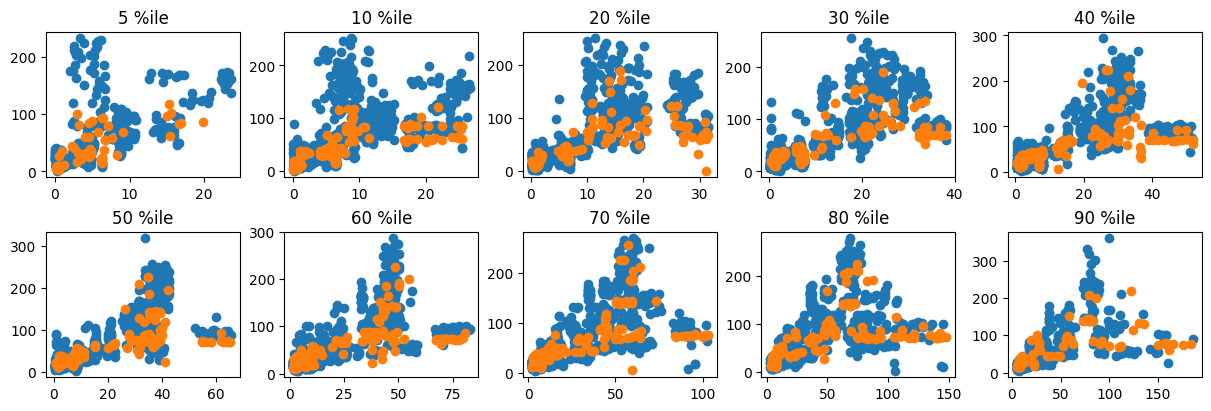

In [576]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4), constrained_layout=True)
# nobridge_wQ = wQ.loc[wQ.index.get_level_values('site_no').isin(nobridge)]
# paired_Qw['color'] = paired_Qw.index.get_level_values('site_no').map(cs)
for i in range(len(bins)):
    print(i)
    ax = axs.flatten()[i]
    df = paired_Qw.loc[paired_Qw.Q_percentile_bin == i].reset_index()
    ax.scatter(df.Q_cms, df.overall_mean_width)
    ax.scatter(df.Q_cms, df.chan_width)
    ax.set_title(f'{int(100 * bins[i])} %ile')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_xlim(0, 1.1 * max(df.Q_cms))
    # ax.set_ylim(0, 1.1 * max(df.sat_width_m))


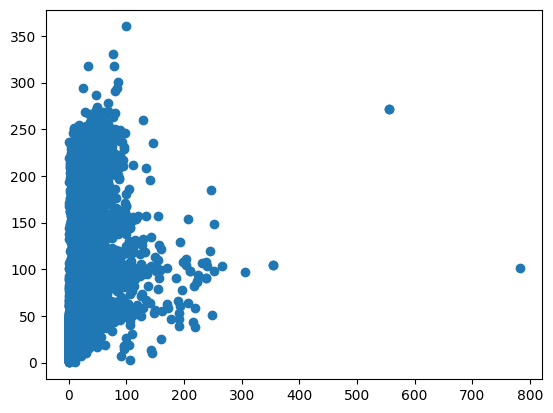

In [554]:
plt.scatter(paired_Qw.Q_cms, paired_Qw.overall_mean_width)

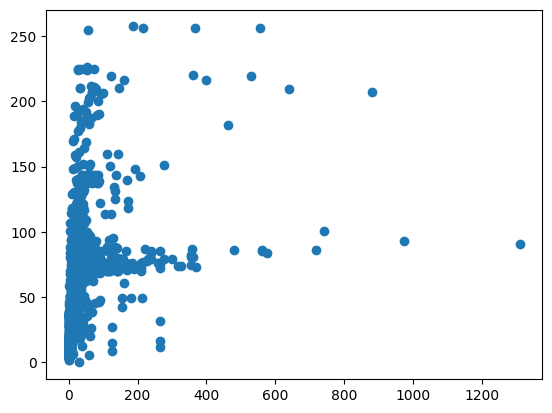

In [555]:
plt.scatter(paired_Qw.Q_cms, paired_Qw.chan_width)

,geometry,index_right,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4
0,POINT (-100.97122 42.38166),155797,74023763,26.871380,19.820402,1.355743,0.001509,804.786598,3,40.6,0.001509,74023660,2,74023843,74027608,0,0
1,POINT (-100.92711 42.37663),155797,74023763,26.871380,19.820402,1.355743,0.001509,804.786598,3,40.6,0.001509,74023660,2,74023843,74027608,0,0
2,POINT (-100.98443 42.38957),155797,74023763,26.871380,19.820402,1.355743,0.001509,804.786598,3,40.6,0.001509,74023660,2,74023843,74027608,0,0
3,POINT (-100.89361 42.36926),155797,74023763,26.871380,19.820402,1.355743,0.001509,804.786598,3,40.6,0.001509,74023660,2,74023843,74027608,0,0
4,POINT (-100.9741 42.38328),155797,74023763,26.871380,19.820402,1.355743,0.001509,804.786598,3,40.6,0.001509,74023660,2,74023843,74027608,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19495,POINT (-105.11308 42.62753),154703,74022669,8.996551,6.048021,1.487520,0.001000,38498.088145,5,9.0,0.001000,74022668,2,74022670,74028098,0,0
19496,POINT (-105.28691 42.64559),154707,74022673,15.986241,9.994169,1.599557,0.000918,37959.974075,5,14.7,0.000918,74022672,2,74022674,74028138,0,0
19497,POINT (-105.39551 42.77198),154713,74022679,3.875141,3.095130,1.252012,0.001160,36519.073317,5,4.5,0.001160,74022678,2,74022680,74028469,0,0
19498,POINT (-105.35222 42.65969),154709,74022675,2.264979,1.765460,1.282939,0.001543,37063.478629,5,3.5,0.001543,74022674,2,74022676,74024951,0,0
